In [615]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

In [573]:
# Bird object with attributes pos (2-D vector), vel (2-D vector), [axis (?)]

class boid:
    def __init__(self, pos_x, pos_y, vel_x, vel_y):
        self.pos = np.array([pos_x, pos_y])
        self.vel = np.array([vel_x, vel_y])
        
    def move(self, goal, mu, dt):
        self.vel = (1 - mu) * self.vel + mu * goal
        self.vel = self.vel / np.linalg.norm(self.vel)
        self.pos += dt * self.vel

In [533]:
# Magnitude function

def mag(vec):
    magnitude = np.linalg.norm(vec)
    return magnitude

In [534]:
# Angle_diff (find angle between two vectors in radians) function

def angle_diff(vec1, vec2):
    angle = np.arccos(np.dot(vec1, vec2)/(mag(vec1)*mag(vec2)))
    return angle

In [535]:
# Get_neighbors function finds other boids in the field of view

# Takes: "self" = self boid, "others" = list of other boids, "radius" = radius of vision, "angle" = field of view
# Returns: a list of the boids in the field of view

def get_neighbors(self, others, radius, angle):
    boids = []
    for other in others:
        
        # if other boid is itself, skip it
        if other is self:
            continue

        offset = other.pos - self.pos

        # if not in range, skip it
        if mag(offset) > radius:
            continue

        # if not within viewing angle, skip it
        if angle_diff(self.vel, offset) > angle:
            continue

        # otherwise add it to the list
        boids.append(other)

    return boids

In [536]:
# Get_neighbors tester

me = boid(0, 0, 1, 0) # self boid with direction on positive x-axis
b2 = boid(1, 0, 0, 0) # other boid position (1, 0) should be in view
b3 = boid(0, 1, 0, 0) # other boid position (0, 1) should be out of view (angle)
b4 = boid(3, 0, 0, 0) # other boid position (0, 1) should be out of view (distance)
b5 = boid(1, -0.2, 0, 0) # other boid position (1, -0.2) should be in view
o = [b2, b3, b4, b5]

radius = 2
angle = np.pi/4

neighbors = get_neighbors(me, o, radius, angle)
for i, item in enumerate(neighbors):
    print(neighbors[i].pos)
    
# Should print (1, 0) and (1, -0.2) representing positions of b1 and b5, the two boids in the field of view

[1 0]
[ 1.  -0.2]


In [729]:
# Center function returns a normalized vector pointing at the origin (our fixed center of mass)

def center(self):
    center_point = np.array(-self.pos) / mag(self.pos)
    return center_point

In [730]:
# Center tester

b4 = boid(3, 0, 1, 1) # boid at position (3, 0) needs to get normalized to mag = 1

center(b4)

# Should print (1, 0)

array([-1.,  0.])

In [539]:
# Avoid function returns a normalized vector pointing directly away from the nearest visible boid

def avoid(self, others, radius, angle):
    
    # Find all visible_boids using get_neighbors
    visible_boids = get_neighbors(self, others, radius, angle)
    
    # If no visible_boids, return an empty vector
    if not visible_boids:
        return np.array([0, 0])
    
    # Find the nearest_boid out of the visible_boids
    nearest_boid = None
    min_distance = float('inf')  # Set initial min_distance to infinity

    for other_boid in visible_boids:
        distance = mag(other_boid.pos - self.pos)

        if distance < min_distance:
            nearest_boid = other_boid
            min_distance = distance
            
    # If no nearest_boid, return an empty vector
    if not nearest_boid:
        return np.array([0, 0])
    
    # Return a normalized vector pointing directly away from nearest_boid
    offset = nearest_boid.pos - self.pos
    
    if mag(offset) == 0:
        print("Warning: Avoidance offset magnitude is zero.")
        run_away = np.array([0, 0])
    else:
        run_away = np.array(-offset) / mag(offset)
    
    return run_away

In [540]:
# Avoid tester

me = boid(0, 0, 0, 0)
c1 = boid(2, 1, 0, 0)
c2 = boid(2, 2, 0, 0)
c3 = boid(1, 0, 0, 0) # Nearest boid
c4 = boid(5, 2, 0, 0)
c = [c1, c2, c3, c4]

print(avoid(me, c, 10, 2*np.pi)) # Field of view encompasses all boids in c

# Should print (-1, 0) as that is the vector pointing directly away from the nearest boid, c3

print(avoid(me, c, 0.2, 2*np.pi)) # Tiny field of view, no boids in vision

# Should print (0, 0) as no boids are visible

[-1.  0.]
[0 0]


/var/folders/dq/17k9n8_50ln7kw09jmqd7czm0000gn/T/ipykernel_96134/1352719432.py:4: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(np.dot(vec1, vec2)/(mag(vec1)*mag(vec2)))


In [541]:
# Copy function returns a normalized vector that matches the velocity of visible boids

def copy(self, others, radius, angle):
    
    # Find all visible_boids using get_neighbors
    visible_boids = get_neighbors(self, others, radius, angle)
    
    # Check if no visible_boids
    if not visible_boids:
        print("Warning: No visible boids found.")
    
    # Add together all velocities of visible_boids to represent copying directions of all visible_boids
    velocities = []
    for i, item in enumerate(visible_boids):
        velocity = visible_boids[i].vel
        velocities.append(velocity)
        
    # Check if all velocities = 0
    if all(np.all(vel == 0) for vel in velocities):
        print("Warning: All visible boids have zero velocity.")
            
    # Return a normalized vector of aligned velocities
    if mag(np.sum(velocities, axis=0)) == 0:
        print("Warning: Copy velocity vector magnitude is zero.")
        follow_the_flock = np.array([0, 0])
    else:
        follow_the_flock = np.sum(velocities, axis=0) / mag(np.sum(velocities, axis=0))
    
    return follow_the_flock

In [542]:
# Copy tester

me = boid(0, 0, 0, 0)
c1 = boid(2, 1, 1, 1)
c2 = boid(2, 2, -1, 0)
c = [c1, c2]

copy(me, c, 10, 2*np.pi) # Field of view encompasses all boids in c

# Should print (0, 1) as that is the copy vector

/var/folders/dq/17k9n8_50ln7kw09jmqd7czm0000gn/T/ipykernel_96134/1352719432.py:4: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(np.dot(vec1, vec2)/(mag(vec1)*mag(vec2)))


array([0., 1.])

In [621]:
# Set_goal computes the weighted sum of the goals and sets the overall goal

# Takes: self, others, radius, angle
# Returns: normalized weighted goal vector

def set_goal(self, others, radius, angle):
    
    goal = (w_avoid*avoid(self, others, radius, angle) + w_center*center(self)
            + w_copy*copy(self, others, radius, angle))
    
    if mag(goal) == 0:
        print("Warning: Goal vector magnitude is zero.")
        goal_norm = np.array([0, 0])
    else:
        goal_norm = goal / mag(goal)
    
    return [goal_norm, w_avoid*avoid(self, others, radius, angle), w_center*center(self),
                       w_copy*copy(self, others, radius, angle)]

In [544]:
# move updates the velocity, position and attitude of the boid:
# The parameter mu determines how quickly the birds can change speed and direction
# The time step, dt determines how far the boids move.
#def move(self, goal, mu=0.1):
    #self.vel = (1-mu) * self.vel + mu * goal
    #self.vel = self.vel / mag(self.vel)

    #self.pos += dt * self.vel

### Simulation

In [731]:
num_boids = 10  # Number of boids
num_steps = 6  # Number of time steps in the simulation
mu = 0.1  # Speed/direction change factor
dt = 1  # Time step size

radius = 5
angle = np.pi

w_avoid = 0/3
w_center = 6/3
w_copy = 0/3

print('Wsum', w_avoid + w_center + w_copy)

Wsum 2.0


In [732]:
# Initialize boids with random positions and 0 velocity
np.random.seed(1)
boids = [boid(pos_x, pos_y, -0.1, -0.1) 
         for pos_x, pos_y in zip(np.random.uniform(-5, 5, num_boids), 
                                 np.random.uniform(-5, 5, num_boids))]

In [733]:
# Check initial positions of boids
for i, b in enumerate(boids):
    print(f"Boid {i}: Position = {b.pos}, Velocity = {b.vel}")

Boid 0: Position = [-0.82977995 -0.80805486], Velocity = [-0.1 -0.1]
Boid 1: Position = [2.20324493 1.852195  ], Velocity = [-0.1 -0.1]
Boid 2: Position = [-4.99885625 -2.9554775 ], Velocity = [-0.1 -0.1]
Boid 3: Position = [-1.97667427  3.78117436], Velocity = [-0.1 -0.1]
Boid 4: Position = [-3.53244109 -4.72612407], Velocity = [-0.1 -0.1]
Boid 5: Position = [-4.07661405  1.7046751 ], Velocity = [-0.1 -0.1]
Boid 6: Position = [-3.13739789 -0.82695198], Velocity = [-0.1 -0.1]
Boid 7: Position = [-1.54439273  0.58689828], Velocity = [-0.1 -0.1]
Boid 8: Position = [-1.03232526 -3.59613061], Velocity = [-0.1 -0.1]
Boid 9: Position = [ 0.38816734 -3.01898511], Velocity = [-0.1 -0.1]


In [734]:
plt.figure(figsize=(10, 6))
colors = plt.cm.tab10(np.linspace(0, 1, num_boids))

<Figure size 1000x600 with 0 Axes>

Boid 0: Position = [-0.82977995 -0.80805486]
Boid 0: Avoid = [ 0. -0.], Center = [1.43284638 1.39533195], Copy = [-0. -0.]
Boid 0: Goal = [0.71642319 0.69766597]
Boid 1: Position = [2.20324493 1.852195  ]
Boid 1: Avoid = [0. 0.], Center = [-1.53090682 -1.28698263], Copy = [-0. -0.]
Boid 1: Goal = [-0.76545341 -0.64349132]
Boid 2: Position = [-4.99885625 -2.9554775 ]
Boid 2: Avoid = [-0.  0.], Center = [1.72161047 1.01786904], Copy = [-0. -0.]
Boid 2: Goal = [0.86080524 0.50893452]
Boid 3: Position = [-1.97667427  3.78117436]
Boid 3: Avoid = [0. 0.], Center = [ 0.92656412 -1.77242177], Copy = [-0. -0.]
Boid 3: Goal = [ 0.46328206 -0.88621088]
Boid 4: Position = [-3.53244109 -4.72612407]
Boid 4: Avoid = [ 0. -0.], Center = [1.19736218 1.60197497], Copy = [-0. -0.]
Boid 4: Goal = [0.59868109 0.80098749]
Boid 5: Position = [-4.07661405  1.7046751 ]
Boid 5: Avoid = [-0. -0.], Center = [ 1.84517438 -0.77157729], Copy = [-0. -0.]
Boid 5: Goal = [ 0.92258719 -0.38578864]
Boid 6: Position = [-3

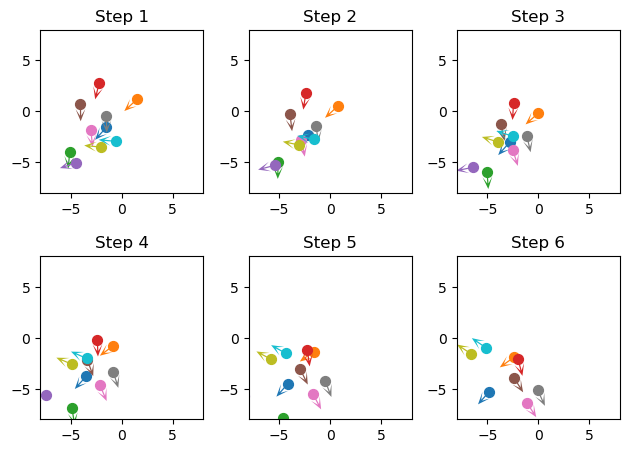

In [738]:
# Simulation loop
for step in range(num_steps):
    # Calculate the goal and move each boid
    for i, b in enumerate(boids):
        # Print boid position
        print(f"Boid {i}: Position = {b.pos}")
        
        # Update goal
        goal_list = set_goal(b, boids, radius, angle)
        print(f"Boid {i}: Avoid = {goal_list[1]}, Center = {goal_list[2]}, Copy = {goal_list[3]}")
        goal = goal_list[0]
        
        # Check boid goals
        print(f"Boid {i}: Goal = {goal}")
        
        # Update position and velocity
        b.move(goal, mu, dt)
    
    # Check boid positions
    #for i, b in enumerate(boids):
        #print(f"Boid {i}: Position = {b.pos}, Velocity = {b.vel}")
        
    # Check boid velocities
    #for i, b in enumerate(boids):
        #print(f"Boid {i}: Velocity = {b.vel}")
    
    # Plotting
    plt.subplot(2, 3, step+1)
    for i, b in enumerate(boids):
        plt.scatter(b.pos[0], b.pos[1], color=colors[i], s=50)
        plt.quiver(b.pos[0], b.pos[1], b.vel[0], b.vel[1], color=colors[i], scale=0.6, scale_units='xy', angles='xy',
                  headwidth=8, headlength=10)
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)
    plt.title(f"Step {step+1}")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.tight_layout()

plt.show()

#### Animation

In [616]:
# Initialize boids with random positions and 0 velocity
np.random.seed(1)
boids = [boid(pos_x, pos_y, 0, 0) 
         for pos_x, pos_y in zip(np.random.uniform(-5, 5, num_boids), 
                                 np.random.uniform(-5, 5, num_boids))]

In [617]:
# Check initial positions of boids
for i, b in enumerate(boids):
    print(f"Boid {i}: Position = {b.pos}, Velocity = {b.vel}")

Boid 0: Position = [-0.82977995 -0.80805486], Velocity = [0 0]
Boid 1: Position = [2.20324493 1.852195  ], Velocity = [0 0]
Boid 2: Position = [-4.99885625 -2.9554775 ], Velocity = [0 0]
Boid 3: Position = [-1.97667427  3.78117436], Velocity = [0 0]
Boid 4: Position = [-3.53244109 -4.72612407], Velocity = [0 0]
Boid 5: Position = [-4.07661405  1.7046751 ], Velocity = [0 0]
Boid 6: Position = [-3.13739789 -0.82695198], Velocity = [0 0]
Boid 7: Position = [-1.54439273  0.58689828], Velocity = [0 0]
Boid 8: Position = [-1.03232526 -3.59613061], Velocity = [0 0]
Boid 9: Position = [ 0.38816734 -3.01898511], Velocity = [0 0]


In [ ]:
# creating a blank window 
# for the animation  
fig = plt.figure()  
axis = plt.axes(xlim =(-8, 8), 
                ylim =(-8, 8))  
  
line, = axis.plot([], [], lw = 2)  
   
# what will our line dataset 
# contain? 
def init():  
    line.set_data([], [])  
    return line,  
   
# initializing empty values 
# for x and y co-ordinates 
xdata, ydata = [], []  
   
# animation function  
def animate(i):  
    # t is a parameter which varies 
    # with the frame number 
    t = 0.1 * i  
       
    # x, y values to be plotted  
    x = t * np.sin(t)  
    y = t * np.cos(t)  
       
    # appending values to the previously  
    # empty x and y data holders  
    xdata.append(x)  
    ydata.append(y)  
    line.set_data(xdata, ydata)  
      
    return line, 
   
# calling the animation function      
anim = animation.FuncAnimation(fig, animate, init_func = init,  
                               frames = 500, interval = 20, blit = True)  
   
# saves the animation in our desktop 
anim.save('growingCoil.mp4', writer = 'ffmpeg', fps = 30) 

AttributeError: module 'matplotlib.animation' has no attribute 'save'

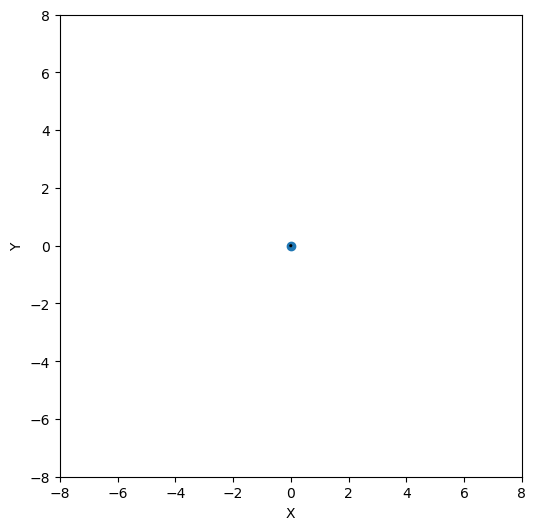

In [619]:
# Set up the plot
fig, ax = plt.subplots(figsize=(6, 6))
sc = plt.scatter([0], [0])
quiver = plt.quiver([0], [0], [0], [0], angles='xy', scale_units='xy', scale=1)

# Set axis limits and labels
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('X')
ax.set_ylabel('Y')

def init():
    """Initialize the scatter and quiver objects."""
    sc.set_offsets([[0, 0]])
    quiver.set_offsets([[0, 0]])
    quiver.set_UVC([0], [0])
    return sc, quiver

def update(frame):
    """Update the scatter plot."""
    positions = []
    velocities = []
    
    # Calculate the goal and move each boid
    for b in boids:
        # Update goal
        goal = set_goal(b, boids, radius, angle)
        
        # Update position and velocity
        b.move(goal, mu, dt)
        
        # Store position and velocity for plotting
        positions.append(b.pos)
        velocities.append(b.vel)
    
    # Update scatter and quiver data
    sc.set_offsets(positions)
    quiver.set_offsets(positions)
    quiver.set_UVC([v[0] for v in velocities], [v[1] for v in velocities])
    return sc, quiver

# Create animation
ani = FuncAnimation(fig, update, frames=100, init_func=init, blit=True)

animation.save('boid_anim.mp4', writer = 'ffmpeg', fps = 30) 

plt.show()